In [1]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time
import copy


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)

    
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels

def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 

def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

In [4]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            img_url = image_paths_list[index_list[index]]
            label_url = label_path_list[index_list[index]]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)

            mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area

In [5]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'



classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

#Create dictonary for id to new id, add color for each id later. 
color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

# read in config file
with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

# print labels
print("There are {} labels in the config file".format(len(labels)))
for label_id, label in enumerate(labels):
    color_id_map[label_id].append(label["color"])
    #print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13

color_label_val_list = get_img_name(color_label_val)
img_val_list = get_img_name(image_val)
print(len(color_label_val_list))
print(len(img_val_list))
#_drivable_id.png
#_drivable_color.png

with open('model_info.json') as a:
    model_info = json.load(a)
    
for key, value in model_info.items():
   
    
    model_info[key]['round'] = 0
    model_info[key]['score'] = 0
    model_info[key]['used_index'] = []
    print(f'Key: {key}, value: {value}')
    print()
    
print('Keys')

#makes a copy for ubc algorithem wont get disurbed by old values
model_info_ubc1 = copy.deepcopy(model_info)

There are 66 labels in the config file
2000
2000
Key: u-net_1585114900, value: {'created': 1585114900, 'training_time': 0, 'data_amount': 140, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.17, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': []}

Key: u-net_1585115750, value: {'created': 1585115750, 'training_time': 0, 'data_amount': 144, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'sigmoid', 'dropout': 0.13, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': []}

Key: u-net_1585116680, value: {'created': 1585116680, 'training_time': 0, 'data_amount': 117, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.48, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': []}

Key: u-net_158511877

In [6]:
'''
y: prediction target (solution)
y_hat: prediction
returns: predictions in percentage
'''
def pixel_score(y, y_hat):
    
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    num_correct = y_hat * y
    width, height, _ = num_correct.shape
    max_score = width * height
    score = num_correct.sum()
    return score/max_score

def iou_score(y, y_hat):
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    height, width, classes = y_hat.shape
    
    score = 0
    
    for i in range(classes):
        y_class = y[:, : , i]
        y_hat_class = y_hat[:, :, i]
                
        true_positiv = y_hat_class * y_class
        true_positiv = true_positiv.sum()
        #print(f'True positive {true_positiv}')
        
        false_pos = np.logical_and(y_hat_class == 1, y_class == 0)
        false_pos = false_pos.sum()
        #print(f'false positive {false_pos}')
        
        false_neg = np.logical_and(y_hat_class == 0, y_class == 1)
        false_neg = false_neg.sum()
        #print(f'false negative: {false_neg}')
        
        total = true_positiv + false_neg + false_pos
        
        if total != 0:
            score += true_positiv / total
        #print(f'score: {score}')
        
        
    return score / classes

(480, 640, 13)


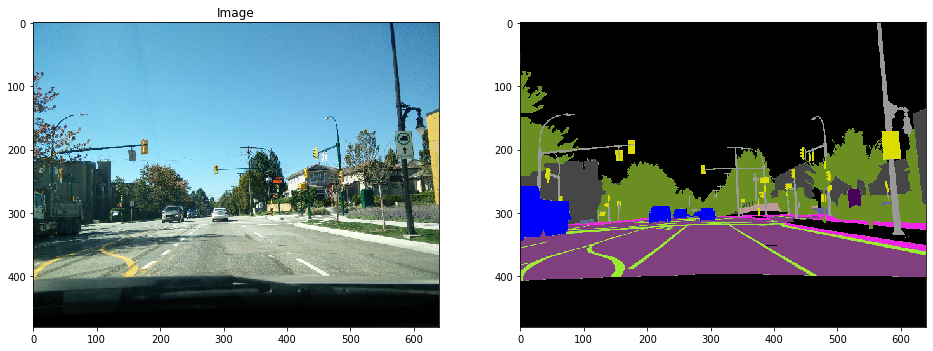

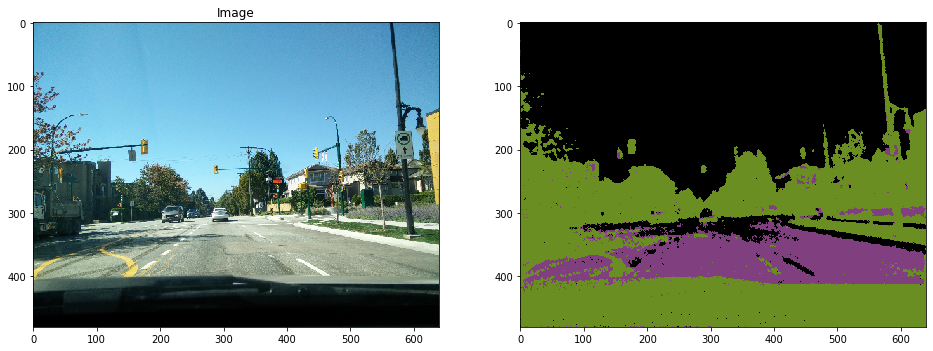

In [7]:
imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
model = load_model(f'seg_models/u-net_1585114900.h5')

img_predicted = model.predict(imges)[0]
target = maskes_to_labels(labels[0]).astype(np.uint8)


print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
compare_img(imges[0], target, 'Image', 'CityScape labels')
compare_img(imges[0], y_train_label, 'Image', 'CityScape labels')




In [8]:
pixel_score(y=labels[0], y_hat=img_predicted)


0.6199088541666666

In [9]:
epsilon = 1
key_list = list(model_info.keys())
num_models = len(list(model_info.keys()))
index_list = range(0, len(img_val_list))
num_trials = len(index_list)
gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)
scores = []
iou_scores = []
means = []
score_counter = []

#calculate old score with new
def calculate_score(rounds, score, old_score):
    return old_score * ((rounds-1)/rounds) + score *(1/rounds)


#output: score of model, mean and std
def try_model(key, imgs, labels, model_info, round_nr, lower_bound=True):
    old_score = model_info[key]['score']
    model_info[key]['round'] += 1
    rounds = model_info[key]['round']
    
    model = load_model(f'seg_models/{key}.h5')
    y_hat, mean, std = predictions_and_uncetrenty(model, 5, imgs)
    
    #make mean and std single values
    mean = mean.mean()
    std = std.mean()
    
    #print(y_hat.shape)
    score = pixel_score(labels[0], y_hat)
    score_iou = iou_score(labels[0], y_hat)
    
    #change from only using mean to lover bound of derivation
    if lower_bound:
        mean_score = calculate_score(rounds, mean - std, old_score)
    else: 
        mean_score = calculate_score(rounds, mean, old_score)
    
    model_info[key]['score'] = mean_score
    model_info[key]['used_index'].append(round_nr)
    
   
    return score, score_iou, mean, std


## Multiarmed Bandit epilon gredy

In [10]:




# run bandit thought validation
for i in range(len(index_list)):
    
    #print(f'round: {i} of {len(index_list)}')
    imgs, labels = next(gen)
    if random.random() > epsilon:
        
        best_model_key = None
        best_score = -np.inf
        
        for key, value in model_info.items():
            if value['score'] > best_score:
                best_score = value['score']
                best_model_key = key
            
        new_score, score_iou,  mean, std = try_model(best_model_key, imgs, labels, model_info, i)
    else:
        #explore
        model_key = random.choice(key_list)
        new_score, score_iou, mean, std = try_model(model_key, imgs, labels, model_info, i)
    
    #print(f'mean: {mean}, std: {std}')
    

    K.clear_session()
    scores.append(new_score)
    iou_scores.append(score_iou)
    score_counter.append(new_score)
    
    means.append(mean)
    #epsilon *= gamma
    
    if i % 10 == 0:
        print(f'round: {i} of {len(index_list)}, score: {sum(score_counter)}')
        score_counter = []
        
        


round: 0 of 2000, score: 0.75373046875
round: 10 of 2000, score: 4.599013671875
round: 20 of 2000, score: 5.834886067708333
round: 30 of 2000, score: 4.157789713541667
round: 40 of 2000, score: 6.323619791666667
round: 50 of 2000, score: 5.1987109375000005
round: 60 of 2000, score: 5.441005859375
round: 70 of 2000, score: 4.6678287760416675
round: 80 of 2000, score: 5.715185546875
round: 90 of 2000, score: 5.445130208333333
round: 100 of 2000, score: 3.9086067708333334
round: 110 of 2000, score: 4.196725260416667
round: 120 of 2000, score: 5.905358072916667
round: 130 of 2000, score: 5.154944661458333
round: 140 of 2000, score: 4.181025390625
round: 150 of 2000, score: 6.168870442708334
round: 160 of 2000, score: 5.030621744791667
round: 170 of 2000, score: 4.370283203125
round: 180 of 2000, score: 5.42701171875
round: 190 of 2000, score: 5.119293619791666
round: 200 of 2000, score: 4.273902994791667
round: 210 of 2000, score: 5.8153678385416665
round: 220 of 2000, score: 5.69409830729

round: 1840 of 2000, score: 5.295315755208334
round: 1850 of 2000, score: 4.236360677083333
round: 1860 of 2000, score: 4.4046809895833325
round: 1870 of 2000, score: 4.547187500000001
round: 1880 of 2000, score: 4.010794270833334
round: 1890 of 2000, score: 4.081012369791667
round: 1900 of 2000, score: 4.486009114583333
round: 1910 of 2000, score: 5.067291666666667
round: 1920 of 2000, score: 4.039296875
round: 1930 of 2000, score: 4.95263671875
round: 1940 of 2000, score: 6.2188085937499995
round: 1950 of 2000, score: 6.377200520833334
round: 1960 of 2000, score: 5.214036458333332
round: 1970 of 2000, score: 5.119267578125
round: 1980 of 2000, score: 4.973717447916667
round: 1990 of 2000, score: 5.130631510416666


 Avg score pr model: 0.4617338198988943


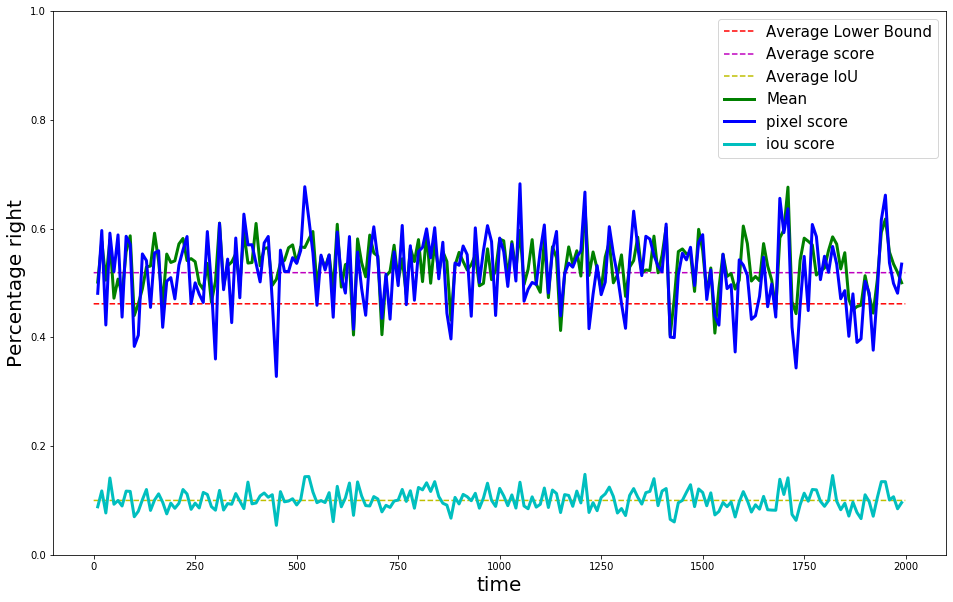

In [20]:

#Reduce the list so graph get more general and easyer to read
def generalize_list(scores, batch_size):
    score_batch = []
    score_reduced = []
    x_akses = []
    for i in range(len(scores)):
        if i % batch_size == 0 and i != 0:
            score_reduced.append(sum(score_batch)/batch_size)
            score_batch = []
            x_akses.append(i)
        score_batch.append(scores[i])
    return score_reduced, x_akses

def score_graph(scores, iou_scores, means, model_info, batch_size):
    plt.figure(figsize=(16, 10))
    score_reduced = []


    model_score_avg = 0
    for key, value in model_info.items():
        model_score_avg += value['score']
    model_score_avg = model_score_avg / num_models


    # x_akses is the same in both instances
    iou_scores_reduced, _ = generalize_list(iou_scores, batch_size)
    score_reduced, x_akses = generalize_list(scores, batch_size)
    mean_reduced, _ = generalize_list(means, batch_size)
    
    print(f' Avg score pr model: {model_score_avg}')
    avg = np.array([model_score_avg for i in range(num_trials)])
    avg_explore = np.array([0.519 for i in range(num_trials)]) # 0.5186551321699284
    avg_iou = np.array([0.101 for i in range(num_trials)]) #0.10119017522614594
    
    #plt.bar(, y_akses_list)
    plt.ylim(0,1)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Percentage right', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(avg, 'r--', label='Average Lower Bound')
    plt.plot(avg_explore, 'm--', label='Average score')
    plt.plot(avg_iou, 'y--', label='Average IoU')
    plt.plot(x_akses, mean_reduced,'g' ,linewidth=3, label='Mean')
    plt.plot(x_akses, score_reduced,'b' ,linewidth=3, label='pixel score')
    plt.plot(x_akses, iou_scores_reduced,'c' ,linewidth=3, label='iou score')
    plt.legend(loc='best', fontsize=15)
    plt.show()

score_graph(scores, iou_scores, means, model_info, batch_size=10)

In [12]:

for key, value in model_info.items():
    print(f'Key: {key}, score: {value["score"]}, rounds: {value["round"]}, time used: {value["used_index"]}')
    print()

Key: u-net_1585114900, score: 0.49102798104286194, rounds: 8, time used: [56, 415, 474, 591, 660, 693, 1530, 1796]

Key: u-net_1585115750, score: 0.3290191173553467, rounds: 5, time used: [93, 970, 980, 1560, 1623]

Key: u-net_1585116680, score: 0.5675318141778309, rounds: 9, time used: [245, 655, 866, 1019, 1078, 1109, 1217, 1511, 1778]

Key: u-net_1585118770, score: 0.6107956022024155, rounds: 4, time used: [451, 885, 1131, 1459]

Key: u-net_1585123137, score: 0.4566778764128685, rounds: 4, time used: [380, 604, 777, 1256]

Key: u-net_1585126633, score: 0.67614905834198, rounds: 5, time used: [190, 1047, 1170, 1705, 1780]

Key: u-net_1585130481, score: 0.3273123417581831, rounds: 7, time used: [57, 582, 882, 1585, 1672, 1677, 1876]

Key: u-net_1585133766, score: 0.6217071413993835, rounds: 1, time used: [77]

Key: u-net_1585136637, score: 0.34894548143659315, rounds: 7, time used: [330, 537, 603, 694, 1534, 1733, 1973]

Key: u-net_1585145765, score: 0.3555818299452464, rounds: 6, tim

Key: FCN_small_1586859717, score: 0.3748901039361954, rounds: 2, time used: [402, 633]

Key: FCN_small_1586859715, score: 0.4454066753387451, rounds: 1, time used: [564]

Key: FCN_small_1586859716, score: 0.35523773729801184, rounds: 6, time used: [267, 536, 668, 684, 725, 1247]

Key: FCN_small_1586859714, score: 0.2993968824545542, rounds: 3, time used: [1022, 1416, 1943]

Key: FCN_1586871103, score: 0.4080480958024661, rounds: 12, time used: [8, 43, 175, 238, 311, 748, 1079, 1211, 1618, 1720, 1815, 1889]

Key: FCN_1586872299, score: 0.5118780732154846, rounds: 6, time used: [449, 495, 530, 554, 1051, 1555]

Key: FCN_1586872417, score: 0.30060164204665596, rounds: 7, time used: [333, 569, 857, 1325, 1390, 1460, 1929]

Key: FCN_1586872415, score: 0.3087475970387458, rounds: 8, time used: [96, 317, 414, 1072, 1279, 1471, 1547, 1727]

Key: FCN_1586873890, score: 0.3512973338365555, rounds: 4, time used: [75, 253, 430, 1531]

Key: FCN_small_1586870437, score: 0.5633364319801331, rounds: 4

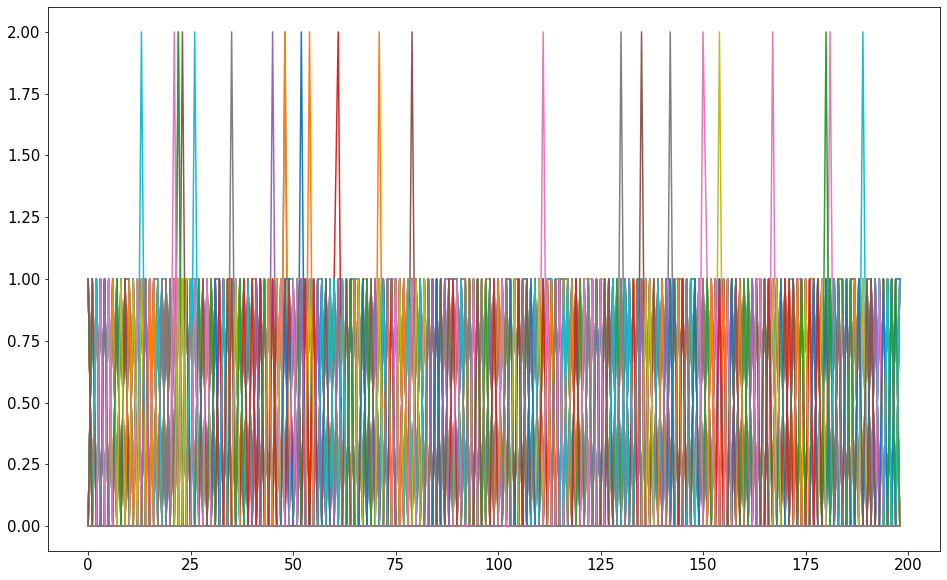

In [13]:
def plot_model_used(model_info, num_models, num_trials, batch_size):
    model_used = np.zeros((num_models, num_trials), dtype=np.uint8)

    #smooth = (len(index_list)+batch_size)//batch_size
    #print(smooth)

    counter = 0
    for key, value in model_info.items():
        #model_used[counter]
        for index in value['used_index']:
            model_used[counter][index] = 1

        counter += 1 

    model_used_smoothe = [] #np.zeros((len(key_list), smooth), dtype=np.uint8)
    counter = 0
    for used in model_used:
        periodic = []
        model_used_smoothe.append([])
        for i in range(len(used)):
            if i % batch_size == 0 and i != 0:
                model_used_smoothe[counter].append(sum(periodic))
                periodic = []
            periodic.append(used[i])
        counter += 1


    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)

    for used_per in model_used_smoothe:
        #print(used_per)
        plt.plot(used_per)
    #print(model_used_smoothe[5])
    #plt.plot(model_used_smoothe[5])
    plt.show()
plot_model_used(model_info, num_models, num_trials, batch_size=10)

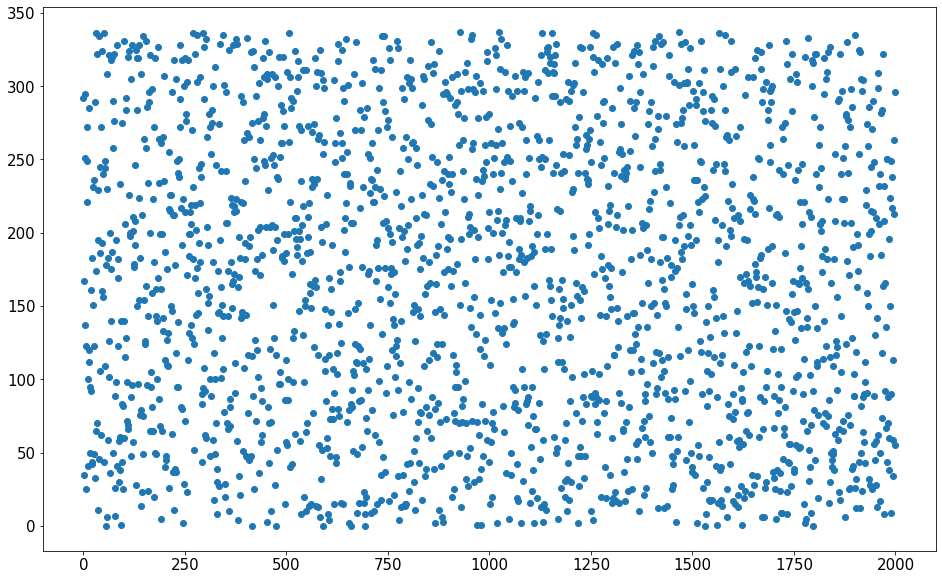

In [14]:

def scatter_model_used(model_info):
    counter = 0
    used_list = np.zeros(num_trials)

    for key, value in model_info.items():

        for used in value['used_index']:
            used_list[used] = counter

        counter += 1
    counter_list = range(num_trials)
    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.scatter(counter_list, used_list)
    plt.show()
scatter_model_used(model_info)

In [19]:
print('Average ressults') #0.3, 0.2
print(f'Score: {np.array(scores).mean()}') #0.6452791124131944, #0.6169490690104167 #0.5193476725260416
print(f'Mean: {np.array(means).mean()}') # 0.6408893465995789, #0.6559882760047913 #0.5316959023475647
print(f'IoU Score: {np.array(iou_scores).mean()}') #0.01849434094551282 #0.13364625770486935

Average ressults
Score: 0.5193476725260416
Mean: 0.5316959023475647
IoU Score: 0.10119017522614594


## UCB1


In [ ]:
gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)

scores_ucb1 = []
iou_scores_ucb1 = []
means_ucb1 = []
score_counter_ucb1 = []



def ucb1_score(rounds, model_info, c):
    model_round = model_info['round']
    
    if model_round == 0:
        return np.inf
    #print(f'rounds: {model_info["round"]} ,score: {model_info["score"]} time used: {model_info["used_index"]}')
    explotation = model_info['score']
    explortion = math.sqrt(math.log(rounds)/model_round)
    
    return explotation + c*explortion


# run bandit thought validation
for i in range(len(index_list)):
    
    #print(f'round: {i} of {len(index_list)}')
    imgs, labels = next(gen)

        
    best_model_key = None
    best_score = -np.inf
    printe_score = True
    
    for key, value in model_info_ubc1.items():
        score = ucb1_score(rounds=i, model_info=value, c=0.05) 
        #save some init time
        if score == np.inf:
            if i > num_models:
                print('FAAAAIL')
            best_model_key = key
            break
            
        if printe_score:
            printe_score = False
        
        if score > best_score:
            best_score = score
            best_model_key = key
            
    
    new_score, score_iou, mean, std = try_model(best_model_key, imgs, labels, model_info_ubc1, i)

    
    #print(f'mean: {mean}, std: {std}')
    

    K.clear_session()
    scores_ucb1.append(new_score)
    score_counter_ucb1.append(new_score)
    means_ucb1.append(mean)
    iou_scores_ucb1.append(score_iou)
    #epsilon *= gamma
    
    if i % 10 == 0:
        printe_score = True
        print(f'round: {i} of {len(index_list)}, score: {sum(score_counter_ucb1)}')
        score_counter_ucb1 = []
        


In [ ]:
score_graph(scores_ucb1, iou_scores_ucb1, means_ucb1, model_info_ubc1, batch_size=10)

In [ ]:
for key, value in model_info_ubc1.items():
    print(f'Key: {key}, rounds: {value["round"]} ,score: {value["score"]} time used: {value["used_index"]}')
    print()

In [ ]:
plot_model_used(model_info_ubc1, num_models, num_trials, batch_size=10)

In [ ]:
scatter_model_used(model_info_ubc1)

In [ ]:
print('Average ressults')
print(f'Score: {np.array(scores_ucb1).mean()}')
print(f'Mean: {np.array(means_ucb1).mean()}')

Average ressults 0.005
Score: 0.6762749348958333
Mean: 0.6959035396575928

Average ressults 0.01
Score: 0.6346883984375001
Mean: 0.6770832538604736

Average ressults 0.05
Score: 0.670639118923611
Mean: 0.6933058500289917